# GLM and GQM Log-Likleyhood Values
November 4th 2024

In [1]:
import sys
import os

myhost = os.uname()[1]
print("Running on Computer: [%s]" %myhost)

sys.path.insert(0, '/home/ifernand/Code/') 
dirname = '/home/ifernand/Cloud_SynthData_Proj'

import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt
from scipy import io as sio
import torch
import time
import h5py

# NDN tools
import NDNT
import NDNT.utils as utils
from NDNT.modules.layers import *
from NDNT.networks import *
import NDNT.NDN as NDN
from NTdatasets.conway.synthcloud_datasets import SimCloudData
from NTdatasets.generic import GenericDataset
from ColorDataUtils.multidata_utils import MultiExperiment
import ColorDataUtils.ConwayUtils as CU
from ColorDataUtils import readout_fit
from ColorDataUtils.simproj_utils import *
from NDNT.utils import fit_lbfgs, fit_lbfgs_batch
from NDNT.utils import imagesc   
from NDNT.utils import ss

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device0 = torch.device("cpu")
dtype = torch.float32

%load_ext autoreload
%autoreload 2

Running on Computer: [sc]
Invoking __init__.py for NDNT.utils


## Load Data

In [2]:
# Load RF center and cell key
out_file = 'data/cloud_data_stim_dim120_robs_sqrad_0.3.hdf5' #'data/cloud_data_stim_dim80_robs_sqrad_0.1.hdf5'
with h5py.File(out_file, 'r') as f:
    x_pos = f['x_pos'][:]
    y_pos = f['y_pos'][:]
    cell_key = [str(f['cell_key'][:][i], encoding='utf-8') for i in range(x_pos.shape[0])]
    file_start_pos = list(f['file_start_pos'][:])

In [26]:
cell_names = ['X_OFF', 'X_ON', 'V1_Exc_L4', 'V1_Inh_L4', 'V1_Exc_L2/3', 'V1_Inh_L2/3']
cell_index = {}
for cell in cell_names:
    cell_index[cell] = [i for i, val in enumerate(cell_key) if val == cell]
print(cell_names)

['X_OFF', 'X_ON', 'V1_Exc_L4', 'V1_Inh_L4', 'V1_Exc_L2/3', 'V1_Inh_L2/3']


In [3]:
#out_file = 'data/cloud_data_stim_dim120_robs_sqrad_0.3.hdf5'
start    = time.time()
data     = SimCloudData(file_name=out_file, down_sample=2, num_lags=11)
end      = time.time()
print('CPU Time', end-start, 'sec')

CPU Time 49.7839457988739 sec


In [4]:
stim_dims = data.stim_dims
num_lags = data.num_lags
L  = stim_dims[1]
NC = data[0]['robs'].shape[1]
NT = data.NT
print('stim_dims =', stim_dims)
print('num_lags =', num_lags)
print('L =', L)
print('Number of cells', NC)
print('Number of time points', NT)

stim_dims = [1, 60, 60, 1]
num_lags = 11
L = 60
Number of cells 1705
Number of time points 510000


In [5]:
pxl_x_pos, pxl_y_pos = deg2pxl(x_pos, y_pos, L, down_sample=2)
mu0s = utils.pixel2grid(np.stack((pxl_x_pos,pxl_y_pos),axis=1), L=L)
print('Spatial mu0:', mu0s.shape)

Spatial mu0: (1705, 2)


## Fit GLM and GQM

In [7]:
Treg = 1
Xreg = 10000.0
L1reg = 1.0
GLreg = 10.0

glm_par = Tlayer.layer_dict( 
    input_dims=data.stim_dims, num_filters=1, bias=True, num_lags=data.num_lags, norm_type=0,
    NLtype='softplus', initialize_center=True)
glm_par['reg_vals'] = {'d2x': Xreg, 'd2t': Treg, 'l1': L1reg, 'glocalx': GLreg,'edge_t':10} 

In [8]:
Treg = 1
XregL, XregQ = 10000.0, 10.0
LOCregL, LOCregQ = 10.0, 1000.0
L1regL, L1regQ = 1.0, None

# linear layer
lin_layer = Tlayer.layer_dict( 
    input_dims = data.stim_dims, num_filters=1, bias=False, norm_type=0, 
    NLtype='lin', initialize_center=True, num_lags=data.num_lags,
    reg_vals= {'d2x': XregL, 'd2t': Treg, 'l1': L1regL, 'glocalx': LOCregL,'edge_t':10, 'bcs':{'d2t':1, 'd2x':1}} )

# quadratic layer
quad_layer = Tlayer.layer_dict( 
    input_dims = data.stim_dims, num_filters=2, bias=False, norm_type=0, 
    NLtype='square', initialize_center=True, num_lags=data.num_lags,
    reg_vals= {'d2x': XregQ, 'd2t': Treg, 'l1': L1regQ, 'glocalx': LOCregQ,'edge_t':10, 'bcs':{'d2t':1, 'd2x':1}} )

# set up linear and quadratic network
lin_net =  FFnetwork.ffnet_dict( xstim_n='stim', layer_list = [lin_layer] )
quad_net =  FFnetwork.ffnet_dict( xstim_n='stim', layer_list = [quad_layer] )

# NDN layer that combines quadratic and linear layer
comb_layer = NDNLayer.layer_dict( num_filters=1, NLtype='softplus', bias=True)
comb_layer['weights_initializer'] = 'ones'

# set up combination network
comb_net = FFnetwork.ffnet_dict( xstim_n=None, ffnet_n=[0,1], layer_list=[comb_layer])

In [9]:
glm_list = []
gqm_list = []
for i in range(NC):
    gdata = GenericDataset( {'stim': data[data.train_blks]['stim'], 
                         'robs': data[data.train_blks]['robs'][:,i], 
                         'dfs':data[data.train_blks]['dfs'][:,i]}, device=device)

    
    glm = NDN( layer_list=[glm_par], loss_type='poisson')
    
    glm = glm.to(device)
    fit_lbfgs(glm, gdata[:], verbose=False)
    glm = glm.to(device0)
    glm_list.append(glm)
    print('Cell', i, 'GLM complete')

    gqm = NDN( ffnet_list = [lin_net, quad_net, comb_net], loss_type='poisson')
    gqm.set_parameters(val=False,name='weight',ffnet_target=2)
    
    gqm = gqm.to(device)
    fit_lbfgs(gqm, gdata[:], verbose=False)
    gqm = gqm.to(device0)
    gqm_list.append(gqm)
    print('Cell', i, 'GQM complete')
    print(' ')

    gdata = None

Cell 0 GLM complete
Cell 0 GQM complete
 
Cell 1 GLM complete
Cell 1 GQM complete
 
Cell 2 GLM complete
Cell 2 GQM complete
 
Cell 3 GLM complete
Cell 3 GQM complete
 
Cell 4 GLM complete
Cell 4 GQM complete
 
Cell 5 GLM complete
Cell 5 GQM complete
 
Cell 6 GLM complete
Cell 6 GQM complete
 
Cell 7 GLM complete
Cell 7 GQM complete
 
Cell 8 GLM complete
Cell 8 GQM complete
 
Cell 9 GLM complete
Cell 9 GQM complete
 
Cell 10 GLM complete
Cell 10 GQM complete
 
Cell 11 GLM complete
Cell 11 GQM complete
 
Cell 12 GLM complete
Cell 12 GQM complete
 
Cell 13 GLM complete
Cell 13 GQM complete
 
Cell 14 GLM complete
Cell 14 GQM complete
 
Cell 15 GLM complete
Cell 15 GQM complete
 
Cell 16 GLM complete
Cell 16 GQM complete
 
Cell 17 GLM complete
Cell 17 GQM complete
 
Cell 18 GLM complete
Cell 18 GQM complete
 
Cell 19 GLM complete
Cell 19 GQM complete
 
Cell 20 GLM complete
Cell 20 GQM complete
 
Cell 21 GLM complete
Cell 21 GQM complete
 
Cell 22 GLM complete
Cell 22 GQM complete
 
Cell 23 

## Compute LL

In [16]:
glm_LL_arr = np.zeros(NC)
gqm_LL_arr = np.zeros(NC)

for i in range(NC):
    gdata = GenericDataset( {'stim': data[data.val_blks]['stim'], 
                         'robs': data[data.val_blks]['robs'][:,i], 
                         'dfs':data[data.val_blks]['dfs'][:,i]}, device=device)
    
    glm_LL = glm_list[i].eval_models(gdata[:], device=device, batch_size=3, null_adjusted=True)
    gqm_LL = gqm_list[i].eval_models(gdata[:], device=device, batch_size=3, null_adjusted=True)

    glm_LL_arr[i] = glm_LL[0]
    gqm_LL_arr[i] = gqm_LL[0]

    print('Cell', i, 'LL complete')
    gdata = None

Cell 0 LL complete
Cell 1 LL complete
Cell 2 LL complete
Cell 3 LL complete
Cell 4 LL complete
Cell 5 LL complete
Cell 6 LL complete
Cell 7 LL complete
Cell 8 LL complete
Cell 9 LL complete
Cell 10 LL complete
Cell 11 LL complete
Cell 12 LL complete
Cell 13 LL complete
Cell 14 LL complete
Cell 15 LL complete
Cell 16 LL complete
Cell 17 LL complete
Cell 18 LL complete
Cell 19 LL complete
Cell 20 LL complete
Cell 21 LL complete
Cell 22 LL complete
Cell 23 LL complete
Cell 24 LL complete
Cell 25 LL complete
Cell 26 LL complete
Cell 27 LL complete
Cell 28 LL complete
Cell 29 LL complete
Cell 30 LL complete
Cell 31 LL complete
Cell 32 LL complete
Cell 33 LL complete
Cell 34 LL complete
Cell 35 LL complete
Cell 36 LL complete
Cell 37 LL complete
Cell 38 LL complete
Cell 39 LL complete
Cell 40 LL complete
Cell 41 LL complete
Cell 42 LL complete
Cell 43 LL complete
Cell 44 LL complete
Cell 45 LL complete
Cell 46 LL complete
Cell 47 LL complete
Cell 48 LL complete
Cell 49 LL complete
Cell 50 LL

In [27]:
glm_LL_dict = {}
gqm_LL_dict = {}
for cell in cell_names:
    glm_LL_dict[cell] = glm_LL_arr[cell_index[cell]]
    gqm_LL_dict[cell] = gqm_LL_arr[cell_index[cell]]

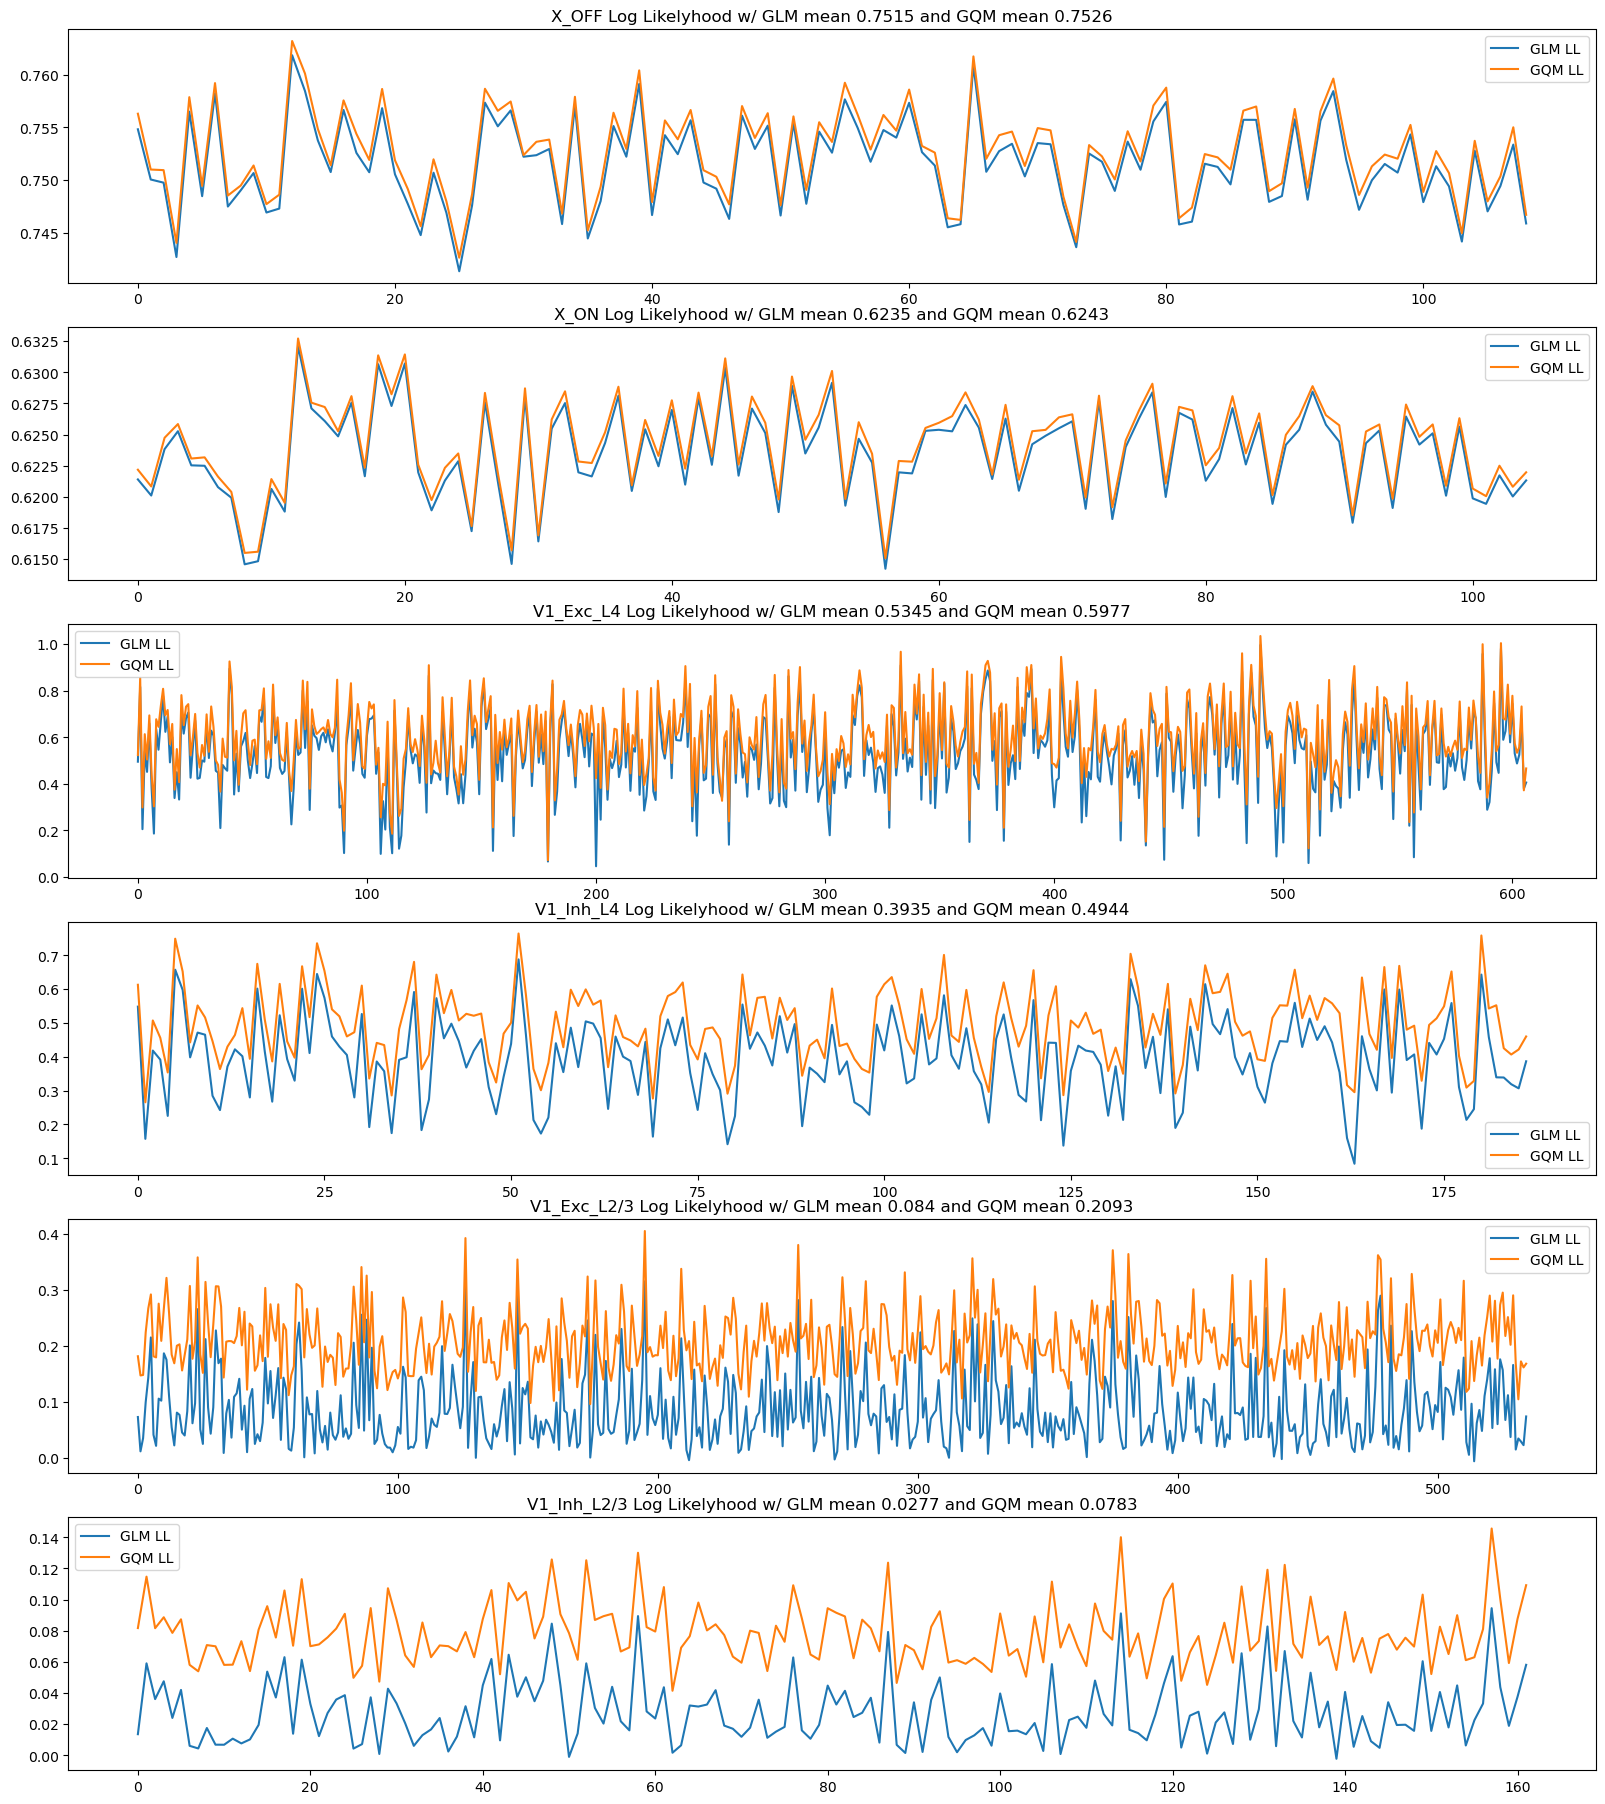

In [28]:
ss(6,1)
for i, cell in enumerate(cell_names):
    plt.subplot(6,1,i+1)
    plt.plot(glm_LL_dict[cell], label="GLM LL")
    plt.plot(gqm_LL_dict[cell], label="GQM LL")
    plt.title(cell+' Log Likelyhood w/ GLM mean '+str(np.round(np.mean(glm_LL_dict[cell]),4))+' and GQM mean '+str(np.round(np.mean(gqm_LL_dict[cell]),4)))
    plt.legend()
plt.show()

## Save LL values

In [29]:
import pickle
with open('data/cloud_data_stim_dim_120_sqrad_0.3_GLM_LL.pkl', 'wb') as f:
    pickle.dump(glm_LL_dict, f)
with open('data/cloud_data_stim_dim_120_sqrad_0.3_GQM_LL.pkl', 'wb') as f:
    pickle.dump(gqm_LL_dict, f)